<a href="https://colab.research.google.com/github/SreeDurga28/FakeNewsDetection/blob/main/FakeNewsDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importing the libraries**

In [ ]:
from google.colab import files
import io
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import string
import nltk
from nltk.corpus import stopwords
import itertools
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from wordcloud import WordCloud

**Reading the CSV file**

In [ ]:
uploaded = files.upload()

Saving news.csv to news.csv


In [ ]:
df = pd.read_csv(io.BytesIO(uploaded['news.csv']))
print("Data loaded")
df.head()

Data loaded


,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


**Data analysis**

In [ ]:
df.shape

(6335, 4)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6335 entries, 0 to 6334
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  6335 non-null   int64 
 1   title       6335 non-null   object
 2   text        6335 non-null   object
 3   label       6335 non-null   object
dtypes: int64(1), object(3)
memory usage: 198.1+ KB


In [ ]:
df=df.drop(['Unnamed: 0','title'],axis=1)
df.head()

,text,label
0,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,It's primary day in New York and front-runners...,REAL


# Data Preprocessing

**Convert to Lowercase**

In [ ]:
df['text'] = df['text'].apply(lambda x: x.lower())
df.head()

,text,label
0,"daniel greenfield, a shillman journalism fello...",FAKE
1,google pinterest digg linkedin reddit stumbleu...,FAKE
2,u.s. secretary of state john f. kerry said mon...,REAL
3,"— kaydee king (@kaydeeking) november 9, 2016 t...",FAKE
4,it's primary day in new york and front-runners...,REAL


**Remove Punctuation**

In [ ]:
def punctuation_removal(text):
    all_list = [char for char in text if char not in string.punctuation]
    clean_str = ''.join(all_list)
    return clean_str

df['text'] = df['text'].apply(punctuation_removal)
df.head()

,text,label
0,daniel greenfield a shillman journalism fellow...,FAKE
1,google pinterest digg linkedin reddit stumbleu...,FAKE
2,us secretary of state john f kerry said monday...,REAL
3,— kaydee king kaydeeking november 9 2016 the l...,FAKE
4,its primary day in new york and frontrunners h...,REAL


**Remove Stopwords**

In [ ]:
nltk.download('stopwords')
stop = stopwords.words('english')

df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,text,label
0,daniel greenfield shillman journalism fellow f...,FAKE
1,google pinterest digg linkedin reddit stumbleu...,FAKE
2,us secretary state john f kerry said monday st...,REAL
3,— kaydee king kaydeeking november 9 2016 lesso...,FAKE
4,primary day new york frontrunners hillary clin...,REAL


# Data visualization

**CountPlot**

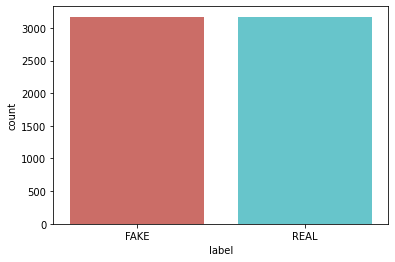

In [ ]:
sns.countplot(x=df['label'], data=df, palette='hls')

**Word cloud for fake and real news**

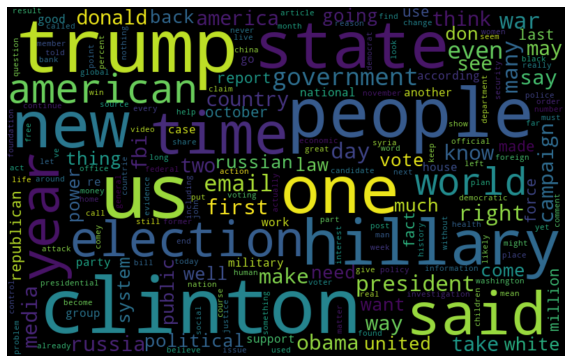

In [ ]:
# Word cloud for fake news

fake_data = df[df["label"] == "FAKE"]
all_words = ' '.join([text for text in fake_data.text])

wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

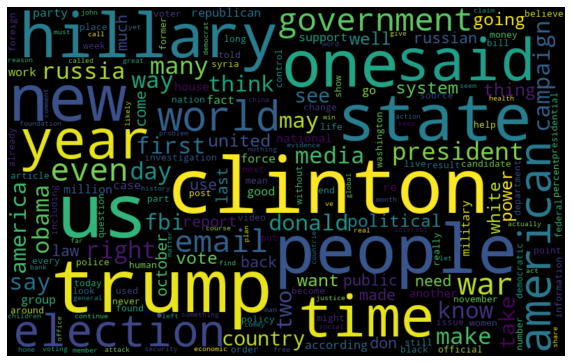

In [ ]:
# Word cloud for real news
real_data = df[df["label"] == "REAL"]
all_words = ' '.join([text for text in fake_data.text])

wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

**Plotting the frequency of each words in fake and real data**

In [ ]:
# Most frequent words counter
token_space = nltk.tokenize.WhitespaceTokenizer()

def counter(text, column_text, quantity):
    all_words = ' '.join([text for text in text[column_text]])
    token_phrase = token_space.tokenize(all_words)
    frequency = nltk.FreqDist(token_phrase)
    df_frequency = pd.DataFrame({"Word": list(frequency.keys()),
                                   "Frequency": list(frequency.values())})
    df_frequency = df_frequency.nlargest(columns = "Frequency", n = quantity)
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = df_frequency, x = "Word", y = "Frequency", color = 'blue')
    ax.set(ylabel = "Count")
    plt.xticks(rotation='vertical')
    plt.show()

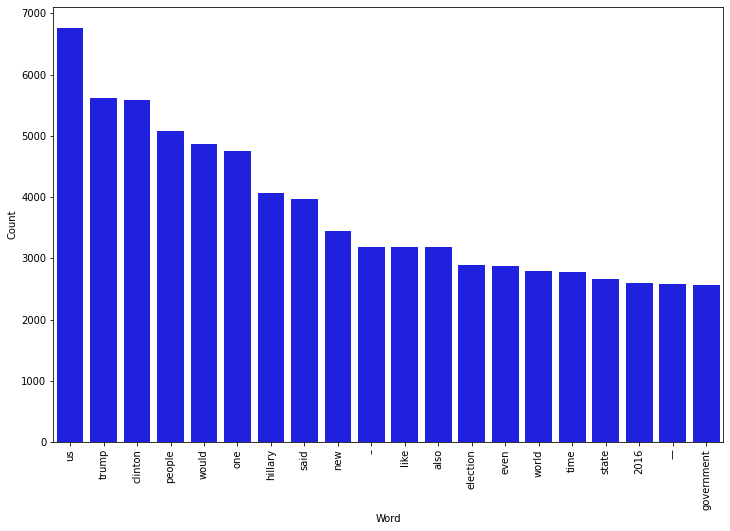

In [ ]:
# Most frequent words in fake news
counter(df[df["label"] == "FAKE"], "text", 20)

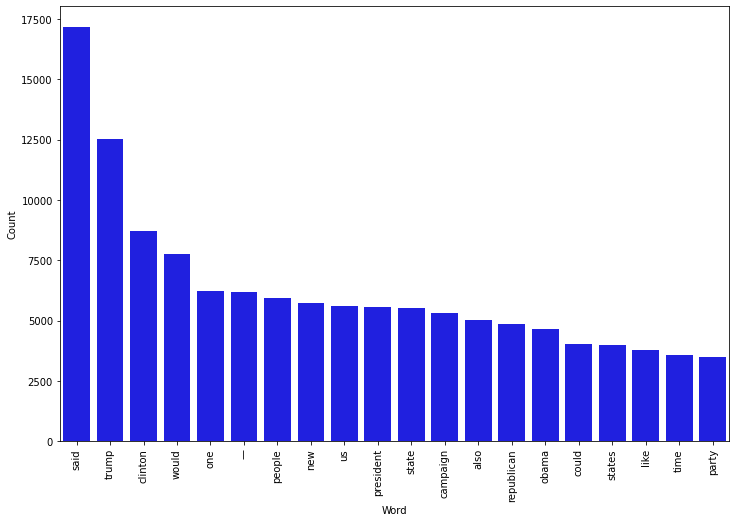

In [ ]:
# Most frequent words in real news
counter(df[df["label"] == "REAL"], "text", 20)

**Plotting Confusion Matrix**

In [ ]:
# Function to plot the confusion matrix (code from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

**Splitting the data**

In [ ]:
# Split the data
X_train,X_test,y_train,y_test = train_test_split(df['text'], df['label'], test_size=0.3, random_state=42)

**Vectorizing the data**

In [ ]:
tfidfv=TfidfVectorizer()
X_train=tfidfv.fit_transform(X_train)
X_test=tfidfv.transform(X_test)

# Modelling

**Passive Aggressive Classifier**

In [ ]:
pac=PassiveAggressiveClassifier(max_iter=50)
pac.fit(X_train,y_train)
#Predict on the test set and calculate accuracy
y_pred=pac.predict(X_test)
score=accuracy_score(y_test,y_pred)
print(f'Accuracy: {round(score*100,2)}%')

Accuracy: 94.16%


Confusion matrix, without normalization


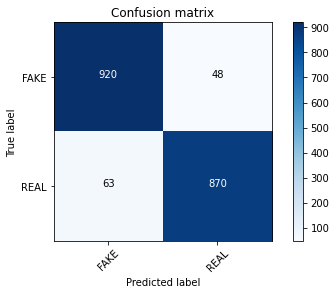

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

**Logistic Regression**

In [ ]:

# Fitting the model
logr = LogisticRegression()
logr.fit(X_train, y_train)

# Accuracy
y_pred = logr.predict(X_test)
score=accuracy_score(y_test,y_pred)
print(f'Accuracy: {round(score*100,2)}%')


Accuracy: 91.69%


Confusion matrix, without normalization


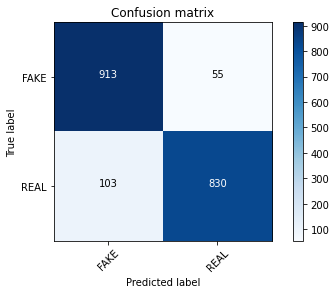

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

**Decision Tree Classifier**

In [ ]:
# Fitting the model
dec = DecisionTreeClassifier()
dec.fit(X_train, y_train)

# Accuracy
y_pred = dec.predict(X_test)
score=accuracy_score(y_test,y_pred)
print(f'Accuracy: {round(score*100,2)}%')

Accuracy: 80.96%


Confusion matrix, without normalization


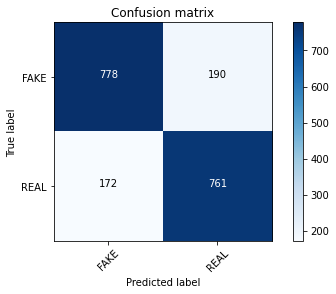

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

**Random Forest Classifier**

In [ ]:
rfc=RandomForestClassifier(n_estimators=50, criterion="entropy")
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
score=accuracy_score(y_test,y_pred)
print(f'Accuracy: {round(score*100,2)}%')


Accuracy: 90.27%


Confusion matrix, without normalization


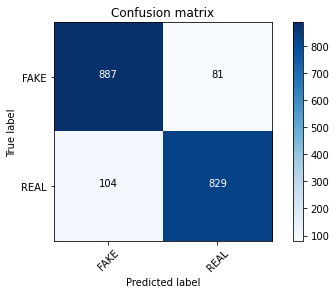

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

**Naive Bayes Classifier**

In [ ]:
#Train the Naive Bayes classifier
mnb=MultinomialNB()
mnb.fit(X_train,y_train)
y_pred = mnb.predict(X_test)
score=accuracy_score(y_test,y_pred)
print(f'Accuracy: {round(score*100,2)}%')

Accuracy: 81.12%


Confusion matrix, without normalization


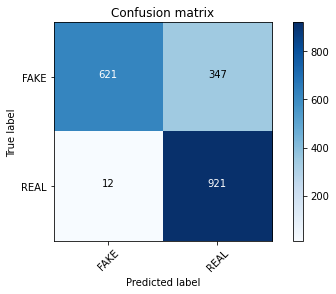

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

**Support Vector Machine**

In [ ]:
#Train the SVM model with linear kernal
svc=SVC(kernel='linear')
svc.fit(X_train,y_train)
y_pred = svc.predict(X_test)
score=accuracy_score(y_test,y_pred)
print(f'Accuracy: {round(score*100,2)}%')

Accuracy: 93.69%


Confusion matrix, without normalization


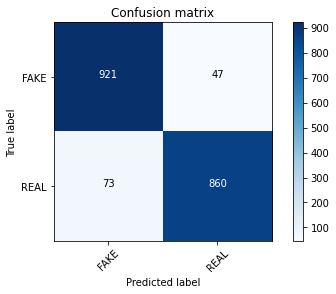

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

**XGBoost**

In [ ]:
xgb=XGBClassifier()
xgb.fit(X_train,y_train)
y_pred = xgb.predict(X_test)
score=accuracy_score(y_test,y_pred)
print(f'Accuracy: {round(score*100,2)}%')

Accuracy: 88.74%


Confusion matrix, without normalization


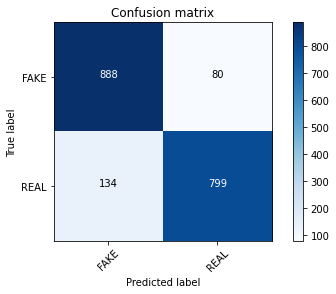

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])